In [25]:
#Importo las librerías

import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import io
from configparser import ConfigParser
import sqlite3
from google.colab import drive
drive.mount ('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
#Hago uso de la API de Coincap (https://docs.coincap.io/), para conocer el valor de las criptomonedas, entre otras cosas.

import http.client

conn = http.client.HTTPSConnection("api.coincap.io")
payload = ''
headers = {}
conn.request("GET", "/v2/assets?limit=2000", payload, headers)
res = conn.getresponse()
data = res.read()

In [27]:
#Paso los datos obtenidos de la API a dataframe.

cadena = data.decode('utf-8')
diccionario = pd.read_json(cadena)
lista = json_normalize(diccionario['data'])
df_crypto = pd.DataFrame(lista)
df_crypto.shape
df_crypto.head()

,id,rank,symbol,name,supply,maxSupply,marketCapUsd,volumeUsd24Hr,priceUsd,changePercent24Hr,vwap24Hr,explorer
0,bitcoin,1,BTC,Bitcoin,19642818.0000000000000000,21000000.0000000000000000,1219832619407.9132220547869552,8277596876.5045130277606460,62100.6934650574689464,-0.1689174287737247,62214.7527353372335882,https://blockchain.info/
1,ethereum,2,ETH,Ethereum,120138874.3052990000000000,None,412338985920.9037986140299174,4761713541.6403763900836081,3432.1861953946795385,0.0939330546617958,3429.4430361746938678,https://etherscan.io/
2,tether,3,USDT,Tether,99179337470.6852100000000000,None,99302831147.6752642304923285,24598906920.8659849427977850,1.0012451552928205,0.1030078115836491,1.0012667948484397,https://www.omniexplorer.info/asset/31
3,binance-coin,4,BNB,BNB,166801148.0000000000000000,166801148.0000000000000000,68355348077.2946694782957596,377157967.1786414301155977,409.8014246118657977,0.6825156367933982,409.3925935661317362,https://etherscan.io/token/0xB8c77482e45F1F44d...
4,solana,5,SOL,Solana,442824138.4458269000000000,None,57743828593.8582716284102405,937788582.1368488310085905,130.3990085014807524,-0.8883651393810488,129.6742243638658802,https://explorer.solana.com/


In [28]:
#Observo los tipos de variables

df_crypto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 2000 non-null   object
 1   rank               2000 non-null   object
 2   symbol             2000 non-null   object
 3   name               2000 non-null   object
 4   supply             1894 non-null   object
 5   maxSupply          830 non-null    object
 6   marketCapUsd       954 non-null    object
 7   volumeUsd24Hr      960 non-null    object
 8   priceUsd           1989 non-null   object
 9   changePercent24Hr  929 non-null    object
 10  vwap24Hr           801 non-null    object
 11  explorer           1940 non-null   object
dtypes: object(12)
memory usage: 187.6+ KB


In [29]:
#Paso los datos al tipo correcto

Vector_float = ['supply', 'maxSupply', 'marketCapUsd', 'volumeUsd24Hr', 'priceUsd', 'changePercent24Hr', 'vwap24Hr']
Vector_VC = ['id', 'symbol', 'name', 'explorer']

df_crypto[Vector_float] = df_crypto[Vector_float].astype('float').round(2)
df_crypto[Vector_VC] = df_crypto[Vector_VC].astype('str')
df_crypto['rank'] = df_crypto['rank'].astype('int')

#Agregro una columna de tipo Timestamp, que me resultará útil.

df_crypto['date'] = pd.Timestamp.today()

#df_crypto.info()
print(df_crypto)

                     id  rank symbol               name        supply  \
0               bitcoin     1    BTC            Bitcoin  1.964282e+07   
1              ethereum     2    ETH           Ethereum  1.201389e+08   
2                tether     3   USDT             Tether  9.917934e+10   
3          binance-coin     4    BNB                BNB  1.668011e+08   
4                solana     5    SOL             Solana  4.428241e+08   
...                 ...   ...    ...                ...           ...   
1995           senderon  1996   SDRN           Senderon  4.562590e+07   
1996              senso  1997  SENSO              SENSO  7.026913e+07   
1997          consensus  1998    SEN      Sentient Coin  1.352263e+09   
1998  sentinel-protocol  1999    UPP  Sentinel Protocol  4.978348e+08   
1999          sentivate  2000  SNTVT          Sentivate  0.000000e+00   

         maxSupply  marketCapUsd  volumeUsd24Hr  priceUsd  changePercent24Hr  \
0     2.100000e+07  1.219833e+12   8.277597

In [30]:
#Verifico los nulos y los reemplazo por el valor medio

df_crypto.isnull().sum()

columnas = ['supply', 'maxSupply', 'marketCapUsd', 'volumeUsd24Hr', 'priceUsd', 'changePercent24Hr', 'vwap24Hr']

#Observo que el dataframe tiene el valor "None" en la columna supply, también debo hacer tratamiento de nulos

df_crypto['supply'] = df_crypto['supply'].replace('None', pd.NA)

valores_medios = df_crypto[columnas].mean()

df_crypto.fillna(valores_medios, inplace = True)

print(df_crypto)

                     id  rank symbol               name        supply  \
0               bitcoin     1    BTC            Bitcoin  1.964282e+07   
1              ethereum     2    ETH           Ethereum  1.201389e+08   
2                tether     3   USDT             Tether  9.917934e+10   
3          binance-coin     4    BNB                BNB  1.668011e+08   
4                solana     5    SOL             Solana  4.428241e+08   
...                 ...   ...    ...                ...           ...   
1995           senderon  1996   SDRN           Senderon  4.562590e+07   
1996              senso  1997  SENSO              SENSO  7.026913e+07   
1997          consensus  1998    SEN      Sentient Coin  1.352263e+09   
1998  sentinel-protocol  1999    UPP  Sentinel Protocol  4.978348e+08   
1999          sentivate  2000  SNTVT          Sentivate  0.000000e+00   

         maxSupply  marketCapUsd  volumeUsd24Hr  priceUsd  changePercent24Hr  \
0     2.100000e+07  1.219833e+12   8.277597

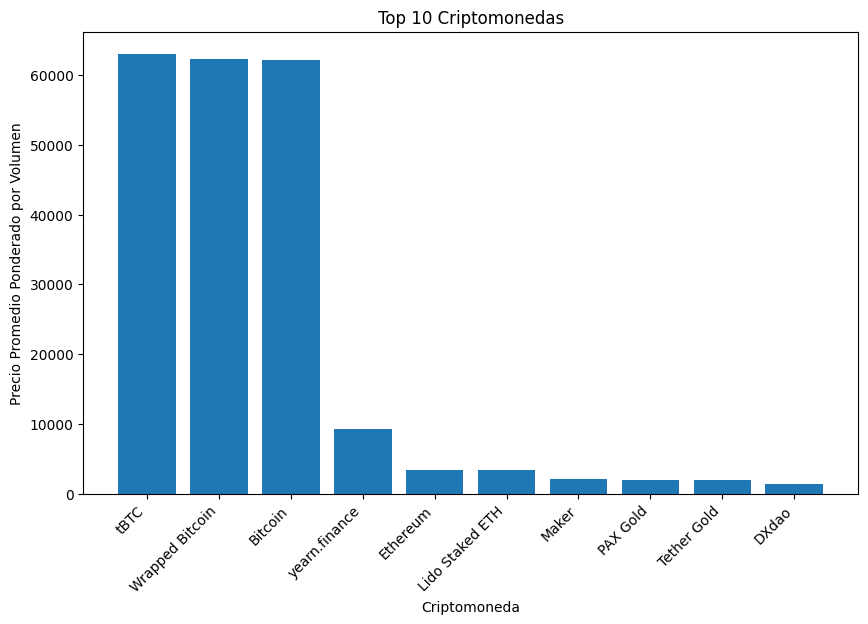

In [31]:
#Creo un top 10 para que el gráfico sea legible.

top_10_criptomonedas = df_crypto.sort_values(by='vwap24Hr', ascending=False).head(10)

# Creo el gráfico de barras para visualizar los datos, en este caso, grafico Criptomonedas vs Precio Promedio Ponderado por Volumen en las últimas 24 horas.

plt.figure(figsize=(10, 6))
plt.bar(top_10_criptomonedas['name'], top_10_criptomonedas['vwap24Hr'])
plt.xlabel('Criptomoneda')
plt.ylabel('Precio Promedio Ponderado por Volumen')
plt.title('Top 10 Criptomonedas')
plt.xticks(rotation=45, ha='right')

# Muestro el gráfico

plt.show()



In [32]:
#Inserto los datos obtenidos en una base de datos SQLite


ruta_db = '/content/gdrive/MyDrive/Database/database_crypto.db'

conn = sqlite3.connect(ruta_db)

#Creo el ID

df_crypto['Id_Crypto'] = range(1, 1 + len(df_crypto))

#Creo la tabla

crear_tabla = '''
CREATE TABLE IF NOT EXISTS tabla_crypto (
       id TEXT,
       rank INTEGER,
       symbol TEXT,
       name TEXT,
       supply REAL,
       maxSupply REAL,
       marketCapUsd REAL,
       volumeUsd24Hr REAL,
       priceUsd REAL,
       changePercent24Hr REAL,
       vwap24Hr REAL,
       explorer TEXT,
       date TEXT,
       Id_Crypto INTEGER PRIMARY KEY
)
'''

#Inserto los datos del dataframe en una tabla.

df_crypto.to_sql('tabla_crypto', conn, index=False, if_exists='replace')

#Creo una consulta para ver id, nombre y precio en dólares

consulta = ''' SELECT id, name, priceUSD FROM tabla_crypto'''

cursor = conn.execute(consulta)

resultados = cursor.fetchall()

# Imprime los resultados

for fila in resultados:
    print(fila)

conn.close()


('bitcoin', 'Bitcoin', 62100.69)
('ethereum', 'Ethereum', 3432.19)
('tether', 'Tether', 1.0)
('binance-coin', 'BNB', 409.8)
('solana', 'Solana', 130.4)
('usd-coin', 'USDC', 1.0)
('xrp', 'XRP', 0.64)
('cardano', 'Cardano', 0.74)
('dogecoin', 'Dogecoin', 0.14)
('avalanche', 'Avalanche', 43.01)
('shiba-inu', 'Shiba Inu', 0.0)
('chainlink', 'Chainlink', 21.39)
('tron', 'TRON', 0.14)
('polkadot', 'Polkadot', 9.26)
('polygon', 'Polygon', 1.1)
('wrapped-bitcoin', 'Wrapped Bitcoin', 62112.79)
('bitcoin-cash', 'Bitcoin Cash', 457.08)
('uniswap', 'Uniswap', 12.55)
('litecoin', 'Litecoin', 91.79)
('internet-computer', 'Internet Computer', 13.16)
('multi-collateral-dai', 'Multi Collateral DAI', 1.0)
('ethereum-classic', 'Ethereum Classic', 33.21)
('filecoin', 'Filecoin', 9.14)
('near-protocol', 'NEAR Protocol', 4.28)
('unus-sed-leo', 'UNUS SED LEO', 4.79)
('stacks', 'Stacks', 2.96)
('stellar', 'Stellar', 0.14)
('vechain', 'VeChain', 0.05)
('crypto-com-coin', 'Crypto.com Coin', 0.14)
('okb', 'OKB',